# Problem

On Windows, Python 3.8+ defaults to WindowsProactorEventLoopPolicy for asyncio. Tornado 6 (used by Jupyter/IPython) does not work with WindowsProactorEventLoopPolicy. So when you try to run Playwright in a notebook:
```
async_browser = create_async_playwright_browser(headless=False)
```
# You get this error:
```
NotImplementedError

```

It’s not a Playwright bug, it’s an asyncio event loop compatibility issue.

# Hack / Fix
- Your instructor’s “hack” is in kernelapp.py inside your Python virtual environment.
- open this file
```
<your-venv>/Lib/site-packages/ipykernel/kernelapp.py
```
- Find the method _init_asyncio_patch:
```
def _init_asyncio_patch(self):
    if sys.platform.startswith("win"):
        import asyncio
        try:
            from asyncio import WindowsProactorEventLoopPolicy, WindowsSelectorEventLoopPolicy
        except ImportError:
            pass
            # not affected
        else:
            if type(asyncio.get_event_loop_policy()) is WindowsProactorEventLoopPolicy:
                # WindowsProactorEventLoopPolicy is not compatible with tornado 6
                # fallback to the pre-3.8 default of Selector
                asyncio.set_event_loop_policy(WindowsSelectorEventLoopPolicy())

```
- Comment out the else block entirely:

```
def _init_asyncio_patch(self):
    if sys.platform.startswith("win"):
        import asyncio
        try:
            from asyncio import WindowsProactorEventLoopPolicy, WindowsSelectorEventLoopPolicy
        except ImportError:
            pass
            # not affected
        # else:
        #     if type(asyncio.get_event_loop_policy()) is WindowsProactorEventLoopPolicy:
        #         asyncio.set_event_loop_policy(WindowsSelectorEventLoopPolicy())

```
- Keep the pass inside the except ImportError.
- Restart your Jupyter kernel.

# Playwright Installation Recap 
- run it on terminal
- This downloads Chromium, Firefox, and WebKit browsers that Playwright can control. Playwright will default to Chromium (Chrome) unless you specify browser_type="firefox" or "webkit".

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import InMemorySaver  

from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
import nest_asyncio
from langchain_community.tools.playwright.utils import create_async_playwright_browser

nest_asyncio.apply()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")

pushover_url = "https://api.pushover.net/1/messages.json"


load_dotenv()

d:\IDM\langchain\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
class State(TypedDict):
    
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)



def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})



@tool("send_push_notification")
def tool_push(text: str):
    """Send a push notification to the user"""
    return push(text)

In [3]:
async_browser =  create_async_playwright_browser(headless=False)
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

In [4]:
import asyncio

for tool in tools:
    print(f"{tool.name} = {tool}")

tool_dict = {tool.name: tool for tool in tools}

navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

await asyncio.sleep(2)

try:
    await navigate_tool.arun({"url": "https://edition.cnn.com/", "timeout": 60000})
    text = await extract_text_tool.arun({})
except Exception as e:
    print("First run error (can be ignored):", e)
    await asyncio.sleep(2)
    await navigate_tool.arun({"url": "https://edition.cnn.com/", "timeout": 60000})
    text = await extract_text_tool.arun({})


click_element = async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\User\AppData\Local\ms-playwright\chromium-1194\chrome-win\chrome.exe> version=141.0.7390.37>
navigate_browser = async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\User\AppData\Local\ms-playwright\chromium-1194\chrome-win\chrome.exe> version=141.0.7390.37>
previous_webpage = async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\User\AppData\Local\ms-playwright\chromium-1194\chrome-win\chrome.exe> version=141.0.7390.37>
extract_text = async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\User\AppData\Local\ms-playwright\chromium-1194\chrome-win\chrome.exe> version=141.0.7390.37>
extract_hyperlinks = async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\User\AppData\Local\ms-playwright\chromium-1194\chrome-win\chrome.exe> version=141.0.7390.37>
get_elements = async_browser=<Browser type=<B

In [5]:
import textwrap
print(textwrap.fill(text))


Breaking News, Latest News and Videos | CNN CNN values your feedback
1. How relevant is this ad to you? 2. Did you encounter any technical
issues? No Video player was slow to load content Video content never
loaded Ad froze or did not finish loading Video content did not start
after ad Audio on ad was too loud Other issues Ad never loaded Ad
prevented/slowed the page from loading Content moved around while ad
loaded Ad was repetitive to ads I've seen previously Other issues
Cancel Submit Thank You! Your effort and contribution in providing
this feedback is much
appreciated. Close Ad Feedback Close icon US World Politics Business
Health Entertainment Style Travel Sports Science Climate Weather
Ukraine-Russia War Israel-Hamas War Games More US World Politics
Business Health Entertainment Style Travel Sports Science Climate
Weather Ukraine-Russia War Israel-Hamas War Games Watch Listen Live TV
Subscribe Sign in My Account Settings Newsletters Topics you follow
Sign out Your CNN account Si

In [6]:
all_tools = tools + [tool_push]


llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    api_key=OPENAI_API_KEY,
    temperature=0.7,
    max_tokens=1024,
    streaming=False,
    timeout=60,
  
    model_kwargs={"top_p": 0.9, "presence_penalty": 0.5}
)

llm_with_tools = llm.bind_tools(all_tools)



def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

d:\IDM\langchain\venv\Lib\site-packages\IPython\core\interactiveshell.py:3639: UserWarning: Parameters {'presence_penalty', 'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  if await self.run_code(code, result, async_=asy):


In [7]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=all_tools))
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

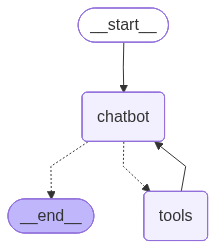

In [8]:
memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
config = {"configurable": {"thread_id": "10"}}

async def chat(user_input: str, history):
    result = await graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
